In [23]:
from fenics import *
from mshr import *
from dolfin import *
import matplotlib.pyplot as plt
#%matplotlib inline 
#% matplotlib notebook
from IPython.display import Image
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import numpy as np
import sympy as sym

Start battery model with simple rectangle mesh geometry. Will add more complex internal geometry once the model is run succesfully. 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


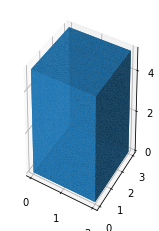

In [32]:
# origin coords
ox = 0.0
oy = 0.0
oz = 0.0
# corner coords
cx = 2.0
cy = 3.0
cz = 5.0

box = Box(dolfin.Point(ox,oy,oz), dolfin.Point(cx,cy,cz))
domain = box
gen = CSGCGALMeshGenerator3D()
mesh = gen.generate(CSGCGALDomain3D(domain))

V = FunctionSpace(mesh, 'P', 1)
Vdg = VectorFunctionSpace(mesh, 'DG', 0)

plot(mesh, "3D mesh")
plt.show()

In [25]:
# define function that describes the heat generation in the battery 
def q(u) : 
    I = 2 # current of the battery (Amps)
    Vol = 8#9.7e-7 # volume of the battery (cm^2)
    R = 10 # Internal Resistance of the battery (Ohms)
    V = .3#-0.4337 # coefficient voltage variation with temperatur in battery cell
    return (I/Vol)*(I*R + V*u)

In [33]:
gD = Constant(1.0) #Expression('x[1]*x[1]', degree = 1) # Constant(100.0) # Dirichlet Boundaeies :top and bottom of battery are exposed to ambient temperature
u_int = Constant(0.0)
#u_int = Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))', degree=2, a=1)
#u_int = Expression('exp(-10*(x[0]*x[0] + x[1]*x[1]))', degree = 1) # Constant(1.0) #Expression('sin(x[0] + x[1])', degree = 1)#Constant(1.0) # Initial condition :begin at same temp as outside
u0 = interpolate(u_int, V)

In [34]:
# defining parts of the boundaries by creating classes
# Left and right side
class Left (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[0], ox)
class Right (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[0], cx)
# Front and Back
class Front (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[1], oy)
class Back (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[1], cy)
# Top and bottom boundaries
class Bottom (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[2], oz)
class Top (SubDomain):
    def inside (self , x , on_boundary):
        return near(x[2], cz)

#create each instance of the classess created above
left = Left()
right = Right()
top = Top()
bottom = Bottom()
front = Front()
back = Back()

# Initialize mesh function for boundary domains and mark
boundaries = MeshFunction("size_t", mesh , 1) #
boundaries.set_all(0) #

left.mark(boundaries , 1)
top.mark(boundaries , 2)
right.mark(boundaries , 3)
bottom.mark(boundaries , 4)

ds = Measure("ds", domain = mesh, subdomain_data = boundaries) #

bc = DirichletBC(V, gD, boundaries, 2) #specify which boundary is Dc

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to create Dirichlet boundary condition.
*** Reason:  User MeshFunction is not a facet MeshFunction (dimension is wrong).
*** Where:   This error was encountered inside DirichletBC.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2018.1.0
*** Git changeset:  bdc641f2c953c1a3bc34ce71d85e3bc8f0cafd2b
*** -------------------------------------------------------------------------


In [ ]:
# Heat flux from batteries on boundaries
gN_left = Constant(0.0) 
gN_right = Constant(0.0)
#declare neumann for top and bottom boundaries if necessary.
#gN_top = Constant(50)
#gN_bottom = Constant(50)

In [ ]:
#convert expressions for u and f into c++ code
x, y = sym.symbols('x[0], x[1]')
u = 1 + x + 2*y
f = - sym.diff(q(u)*sym.diff(u, x), x) - sym.diff(q(u)*sym.diff(u, y), y)
f = sym.simplify(f)
u_code = sym.printing.ccode(u)
f_code = sym.printing.ccode(f)
print('u =', u_code)
print('f =', f_code)

u_D = Expression(u_code, degree = 1)
f = Expression(f_code, degree = 1)

In [ ]:
#define time interval and step size
num_steps = 1000
T = 10.0
dt = T/num_steps
t = 0

In [ ]:
#variational problem
u = TrialFunction(V)
v = TestFunction(V)
#f = q(u) #Constant(1.0)
#f = Expression(f_code, degree = 1)
f = Expression('x[0]*x[1]', degree = 1)#Constant(1.0)
#f = Expression('(I/Vol)*(I*R + V*u)', I = I, Vol = Vol, R = R, Volt = Volt, u = u degree = 1) # This is where the heat source will go (q) function of Temp.

In [ ]:
up = u0 #store u(t=0) in new var

F =  u*v*dx + dt*dot(grad(u), grad(v))*dx - (u0 + dt*f)*v*dx - dt*gN_left*v*ds(1) - dt*gN_right*v*ds(3)

a = lhs(F) #left hand side
L = rhs(F) #right hand side

In [ ]:
A = assemble(a)
u = Function(V)

In [ ]:
vtkfile = File('output/battery_test.pvd')

In [ ]:
# time travel
for n in range(num_steps) :
    t += dt
    
    print("t = ", t)
    
    b = assemble(L)
    bc.apply(A,b)
    solve(A, u.vector(), b)
    #solve(a == L, u, bcs)
    
    n = FacetNormal(mesh)
    
    # compute the power transfer through each boundary
    
    flux = inner(grad(u0), n)*ds(4) #flux through bottom 
    power_bottom = assemble(flux) #integrate flux to get power
    
    flux = inner(grad(u0), n)*ds(2) #flux through top boundary
    power_top = assemble(flux) #integrate flux to get power
    
    flux = inner(grad(u0), n)*ds(3) #flux through right boundary
    power_right = assemble(flux) #integrate flux to get power
    
    flux = inner(grad(u0), n)*ds(1) #flux through left boundary
    power_left = assemble(flux) #integrate flux to get power
    
    #update
    up.assign(u)
    vtkfile << (u,t) #save

In [ ]:
plot(u)
plt.show()

In [ ]:
print("The power transfer through the bottom boundary is {}".format(power_bottom), "Joules")
print("The power transfer through the top boundary is {}".format(power_top), "Joules")
print("The power transfer through the right boundary is {}".format(power_right), "Joules")
print("The power transfer through the left boundary is {}".format(power_left), "Joules")